### <b> Notebook to plot IDF curves from a global coupled climate model (CESM) </b>
#### <b> The simulation is a <font color="red"> 100-year 'control' simulation</font> with pre-industrial climate forcing. Here we are analyzing years <font color="red"> 1970-2021 </font>. </b>
#### <b> Ocean resolution: <font color="red"> 0.1<sup>o</sup></font>, atmosphere/land resolution: <font color="red"> 0.25<sup>o</sup></font>   </b>
#### <b> Data frequency: <font color="red"> 6 hourly </font>, data duration: <font color="red"> 52 years </font>
---

#### <b> Import various modules </b>

In [ ]:
import xarray as xr               #netcdf multidim reading/writing/manipulation
import numpy as np                #numerics
import os                         #operating system commands
import subprocess
import time as timer
import sys
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#import nc_time_axis
import cftime

from tqdm import tqdm

from scipy import stats, signal #Required for detrending data and computing regression
from scipy.stats import t

import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry.polygon import LinearRing

from math import nan

import xgcm
from xgcm import Grid

import glob 

import dask
from dask.distributed import progress
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from dask import delayed # to allow parallel computation

import seaborn as sns
from scipy.stats import genextreme
from statsmodels.distributions.empirical_distribution import ECDF
sns.set()
sns.set_context('notebook')

%matplotlib inline

#### <b> Set plotting defaults </b>

In [2]:
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
plt.rc('figure',titlesize=16)
mpl.rcParams['lines.linewidth'] = 1

#### <b> Request cores, memory and wallclock time </b>

In [ ]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

cluster = SLURMCluster(cores=18, processes=18, memory="384GB",queue="short",
                       walltime="02:00:00")
print(cluster.job_script())
cluster.scale(18)
client = Client(cluster)

---

### <b> Reading in the data </b>

#### <b> Create list of filenames </b>

In [4]:
datadir = './data/'

fstring = 'PRECT'

files = sorted(glob.glob(datadir + '*' + fstring + '*'))

#### <b> Read in just one file to create list of variables to be retrieved from all files </b>
#### <b> Here, we are retrieving PRECT which is the total precipitation (large-scale + convective parameterization) in m/s

In [5]:
ds0=xr.open_dataset(files[0],chunks='auto',decode_cf=False) 
ds0=xr.decode_cf(ds0)
varlist=list(ds0.variables)

droplist=['time','lon','lat','PRECT']

for i in droplist:
    varlist.remove(i)

#### <b> Read in all files and only the variables selected above </b>

In [ ]:
# For 1970-01 to 2021-12, use 30:72
f1=20;f2=72
ds = xr.open_mfdataset(files[f1:f2],chunks='auto',drop_variables=varlist,decode_cf=False)
ds = xr.decode_cf(ds)

ds['time'] = xr.cftime_range(start='1970-01-01 00:00:00',end='2021-12-31 18:00:00',freq='6H',calendar='noleap')
ds

#### <b> Store precipitation in a separate variable and convert to mm/hr </b>

In [7]:
varname = 'PRECT'
prect = ds[varname] * 1e3 * 3600 # conver to mm/hr

#### <b> Identify location where we want to plot the IDF curves (Boston) </b>

In [8]:
#Boston
lat_loc = 42.361145; lon_loc = -71.057083 + 360.
#NYC
#lat_loc = 40.730610; lon_loc = -73.935242 + 360.

#### <b> Pick lon/lat values in the dataset nearest to the above location. </b>

In [ ]:
lat=ds['lat'].isel(time=0); lon=ds['lon'].isel(time=0)

dist = np.sqrt( (lat-lat_loc)**2 + (lon-lon_loc)**2 )
loc_nearest = np.where(dist==np.min(dist))[0][0]

(lon.isel(ncol=loc_nearest).values-360., float(lat.isel(ncol=loc_nearest).values) )

#### <b> 'Persist' the precipitation values at the chosen location </b> 
##### In Dask 'persist' refers to gathering the data into the memory distributed across multiple cores. 

In [10]:
prect_spot = prect.isel(ncol=loc_nearest).persist()

#### <b> Plot the timeseries to check if the magnitudes look reasonable </b> 

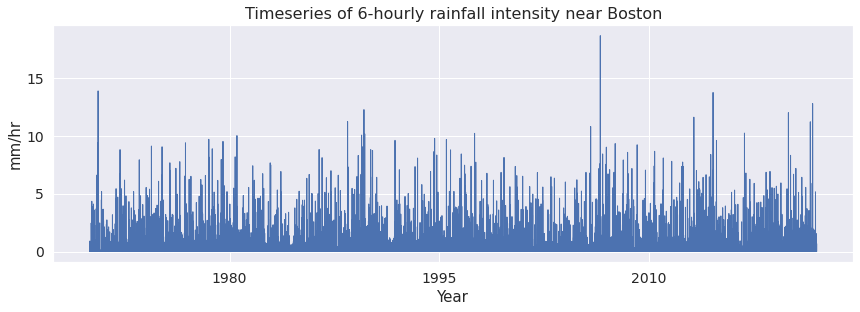

In [19]:
fig,axs=plt.subplots(1,1,figsize=(12,4))
fig.tight_layout()

prect_spot.plot(ax=axs);
axs.grid(True)
axs.set_xlabel('Year',fontsize=15)
axs.set_ylabel('mm/hr',fontsize=15)
axs.set_title('Timeseries of 6-hourly rainfall intensity near Boston',fontsize=16);

---

### <b> Plotting the empirical and Generalized Extreme Value distributions fitted to the data </b>

#### <b> Form the Annual Maximum Series (AMS) for a duration of 12 hours </b>

In [20]:
chunks='auto'

prec_rollmean = prect_spot.rolling(time=2,center=True).mean().chunk(chunks)
prec_ams = prec_rollmean.groupby('time.year').max('time').persist()

#### <b> Plot the probability distribution and the associated empirical kernel (thin line) </b>

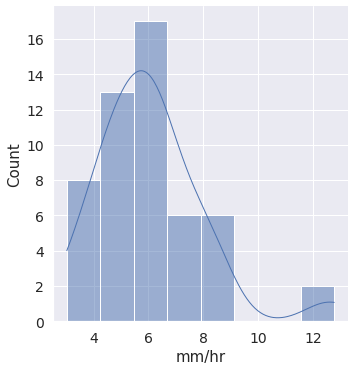

In [24]:
sns.displot(prec_ams,bins=8,kde=True);
plt.xlabel('mm/hr',fontsize=15);
plt.ylabel('Count',fontsize=15);

#### <b> Now, we will fit the GEV probability distribution </b>

In [25]:
gev_ams = genextreme.fit(prec_ams,f0=0)

ecdf_ams = ECDF(prec_ams)

#### <b> Plot the cumulative distribution function (left) and the return period (right) </b>

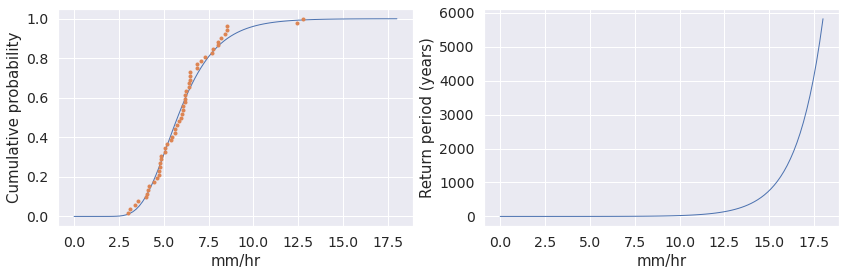

In [32]:
x=np.linspace(0,18,100)

fig,axs=plt.subplots(1,2,figsize=(14,4))
axs.flatten()

axs[0].plot(x,genextreme(*gev_ams).cdf(x));
axs[0].plot(prec_ams,ecdf_ams(prec_ams),'.');
axs[0].set_xlabel('mm/hr',fontsize=15)
axs[0].set_ylabel('Cumulative probability',fontsize=15)

axs[1].plot(x,1/(1-genextreme(*gev_ams).cdf(x)) );
axs[1].set_xlabel('mm/hr',fontsize=15)
axs[1].set_ylabel('Return period (years)',fontsize=15);

#### <b> The above was for a duration of 12 hours, now repeat the exercise for multiple durations </b>

In [33]:
duration = [1, 2, 3, 4, 5]
ndur = len(duration)

idf_table = xr.Dataset(coords=dict(duration=(['duration'],duration)))
idf_table['par1']=xr.DataArray(coords=idf_table.coords)
idf_table['par2']=xr.DataArray(coords=idf_table.coords)
idf_table['par3']=xr.DataArray(coords=idf_table.coords)

prec_ams = np.nan*np.ones(shape=(len(duration),f2-f1))

#### <b> Get GEV parameters for all durations </b>

In [34]:
for it in range(ndur):
    prec_rollmean = prect_spot.rolling(time=duration[it],center=True).mean().dropna('time').chunk(chunks)
    prec_ams[it,:] = prec_rollmean.groupby('time.year').max('time').compute()
    gev_ams = genextreme.fit(prec_ams[it,:],f0=0)
    idf_table['par1'][it]=gev_ams[0]
    idf_table['par2'][it]=gev_ams[1]
    idf_table['par3'][it]=gev_ams[2]

#### <b> Plot the cumulative probabilities and the probability densities for various durations </b>

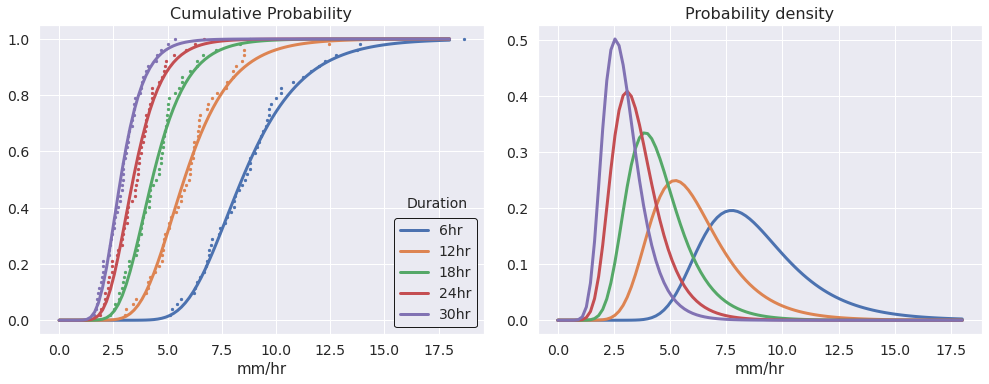

In [38]:
fig,axs=plt.subplots(1,2,figsize=(14,5))
axs.flatten()
fig.tight_layout()

labels=['6hr','12hr','18hr','24hr','30hr']

for it in range(len(duration)):
    gev_params=(idf_table['par1'][it].values,
                idf_table['par2'][it].values,
                idf_table['par3'][it].values)
    dummy=prec_ams[it,:]
    axs[0].plot(x,genextreme(*gev_params).cdf(x),label=labels[it],linewidth=3)
    axs[0].scatter(dummy,ECDF(dummy)(dummy),s=5,label=None);
    axs[1].plot(x,genextreme(*gev_params).pdf(x),label=labels[it],linewidth=3);
    
axs[0].legend(labels,fontsize=14,edgecolor='k',framealpha=1);
axs[0].set_xlabel('mm/hr',fontsize=15)
axs[0].set_title('Cumulative Probability',fontsize=16)
axs[0].text(16,0.4,'Duration',fontsize=14)
axs[1].set_xlabel('mm/hr',fontsize=15)
axs[1].set_title('Probability density',fontsize=16);

#### <b> Define four return periods (2, 10, 25 and 40 years) and obtain the corresponding non-exceedance probabilities </b>

In [39]:
return_period = np.array([2,10,25,40]) 
nrp = len(return_period)

EP = 1/return_period
non_EP = 1-EP

#### <b> Generate the points for the IDF curve by repeating above exercise for different durations </b> 

In [63]:
intensity_matrix = xr.DataArray(np.random.random([ndur,nrp]),dims=['duration','RP'],
                                coords=dict(duration=(['duration'],np.array(duration)*6),
                                            return_period=(['RP'],return_period)) )
for it in range(ndur):
    gev_params=(idf_table['par1'][it],
                idf_table['par2'][it],
                idf_table['par3'][it])
    intensity_matrix[it,:]=genextreme(*gev_params).ppf(non_EP)

#### <b> Generate the IDF curves for the various return periods </b>

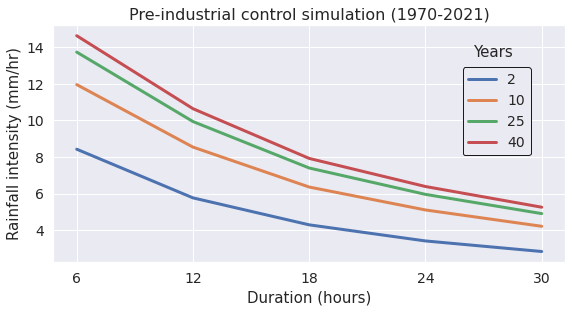

In [181]:
labels=['2', '10', '25', '40']

fig,axs=plt.subplots(1,1,figsize=(8,4))
fig.tight_layout()

axs.plot(intensity_matrix.duration,intensity_matrix.sel(RP=slice(0,None)),linewidth=3)

axs.set_xticks(intensity_matrix.duration);
axs.set_xticklabels(list(np.array(duration)*6))
axs.legend(labels,loc=[0.8,0.45],fontsize=14,edgecolor='k',framealpha=1);
axs.grid(True)
axs.text(26.5,13.5,'Years',fontsize=15)
axs.set_xlabel('Duration (hours)',fontsize=15)
axs.set_ylabel('Rainfall intensity (mm/hr)',fontsize=15)
axs.set_title('Pre-industrial control simulation (1970-2021)',fontsize=16);

---

#### <b> Now we will use the <font color="red"> map_blocks </font> routine from Xarray to parallelize this calculation over the globe </b>

In [11]:
def get_idf_curve(field): 
    
    duration = [1, 2, 3, 4, 5]
    ndur = len(duration)
    
    return_period = np.array([2,10,25,40]) 
    nrp = len(return_period)
    EP = 1/return_period
    non_EP = 1-EP
    f1=20;f2=72

    idf_curve = xr.DataArray(np.zeros([len(field.ncol),ndur,nrp]),
                                dims=['ncol','duration','RP'] )
    
    for n in range(len(field.ncol)):
        for it in range(ndur):
            
            vec = field.isel(ncol=n,drop=True)
            prec_rollmean = vec.rolling(time=duration[it],center=True).mean(dropna=True)
            prec_ams = prec_rollmean.groupby('time.year').max('time').compute()
            
            gev_ams = genextreme.fit(prec_ams,f0=0)
            
            idf_curve[n,it,:]=genextreme(*gev_ams).ppf(non_EP)

    return idf_curve        

#### <b> Map_blocks call  </b>

In [19]:
lincr = 50000
l1 = 100000; l2 = l1 + lincr
subset=dict(ncol=slice(l1,l2))

chunks=dict(ncol=chunksize,time=-1)

field = prect.isel(subset).chunk(chunks)
field = field.persist()

chunks=dict(ncol=chunksize)
idf_curve = np.nan * xr.DataArray(np.ones([len(field.ncol),ndur,nrp]),
                                  dims=['ncol','duration','RP'] ).chunk(chunks)

template = xr.full_like(idf_curve,fill_value=np.nan).chunk(chunks)

idf_curve = xr.map_blocks(get_idf_curve,field,template=idf_curve).compute().rename('idf_curve')

##### <p> <b> The data on the unstructured grid has dimensions (ncol, time) where ncol is a linear index running through all (lon, lat) values. We exploit this by splitting the data into successive chunks along ncol, apply map_blocks simultaneously on each chunk (by running copies of this notebook) and finally stitch the output together to give one file. Then we can use existing ESMF tools to regrid the unstructured data onto a rectilinear grid. The regridded data is now ready for plotting (shown below). </b> </p>

### <b> Global maps of 6-hour rainfall </b>

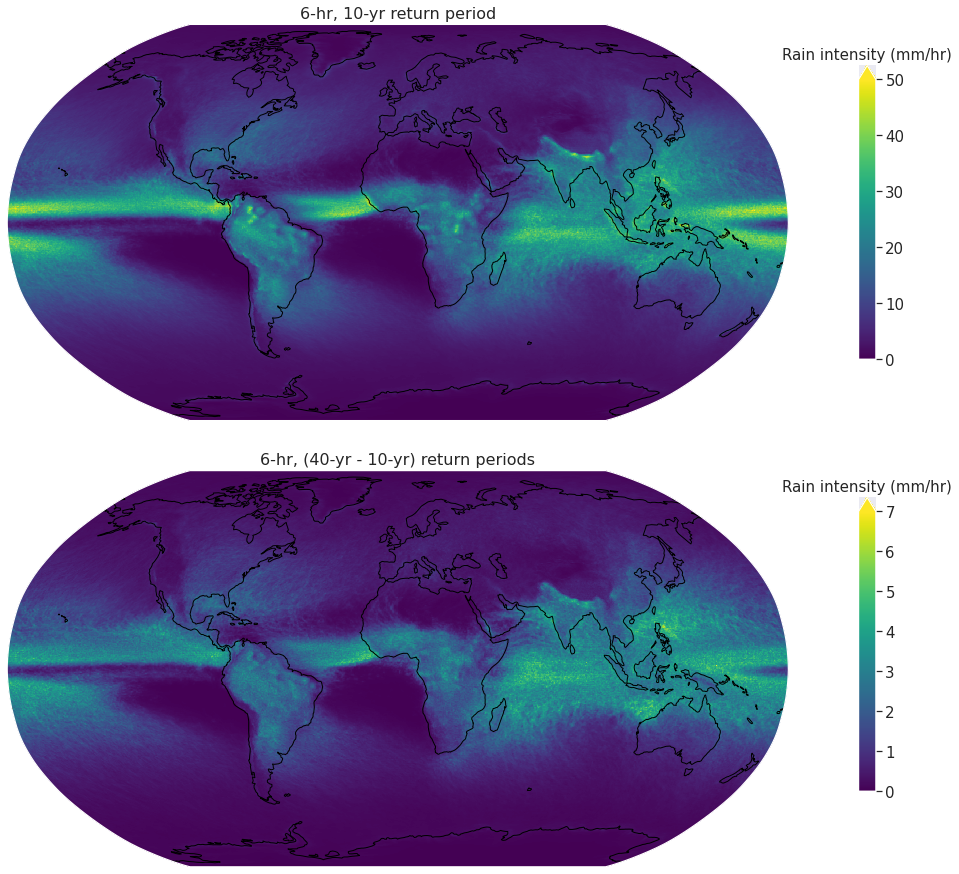

In [78]:
proj = ccrs.Robinson(central_longitude=0) 
pc = ccrs.PlateCarree()

fig,axs=plt.subplots(2,1,figsize=(16,12),sharex=True,subplot_kw=dict(projection=proj))
fig.tight_layout(h_pad=5)
axs.flatten()

axid=0
idf_curve1.plot(ax=axs[axid],transform=pc,add_colorbar=False)
axs[axid].add_feature(cf.COASTLINE) 
axs[axid].set_title('6-hr, 10-yr return period',fontsize=16)
cmin=0; cmax=50;
norm = mpl.colors.Normalize(vmin=cmin, vmax=cmax)
cax = fig.add_axes([0.9, 0.60, 0.015, 0.34])
cb = mpl.colorbar.ColorbarBase(cax, cmap=plt.cm.viridis, norm=norm,
                               orientation='vertical',extend='max')
cb.ax.tick_params(labelsize=15.0)
cb.ax.set_title(r'Rain intensity (mm/hr)',fontdict={'fontsize':15});

axid=1
(idf_curve2-idf_curve1).plot(ax=axs[axid],transform=pc,add_colorbar=False)
axs[axid].add_feature(cf.COASTLINE) 
axs[axid].set_title(r'6-hr, (40-yr - 10-yr) return periods',fontsize=16)
cmin=0; cmax=7;
norm = mpl.colors.Normalize(vmin=cmin, vmax=cmax)
cax = fig.add_axes([0.9, 0.10, 0.015, 0.34])
cb = mpl.colorbar.ColorbarBase(cax, cmap=plt.cm.viridis, norm=norm,
                               orientation='vertical',extend='max')
cb.ax.tick_params(labelsize=15.0)
cb.ax.set_title(r'Rain intensity (mm/hr)',fontdict={'fontsize':15});

---

#### <b> Supplementary information </b>

#### <b> Alternate method using Fitter to fit the GEV probability distribution. </b>
<b> This does not assume the shape parameter to be zero but it turns out to be close to zero, which is why the fitted parameters are not too different from the GEV calculation which does assume that parameter to be zero. </b>

(0.17626717200789765, 7.491029819254642, 2.8410246105498755)

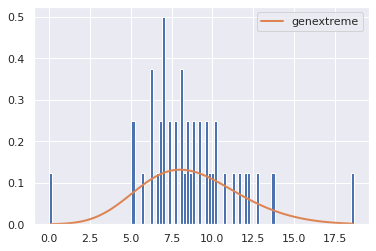

In [64]:
from fitter import Fitter
f = Fitter(prec_ams.values,
           distributions=["genextreme"])

f.fit()
f.summary()

f.fitted_param["genextreme"]